###Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DataLoader, Subset
from timeit import default_timer as timer
import gc
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


###Dataset

In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


traindataset = datasets.CIFAR10(root='./data', train=True,
                                download=True, transform=train_transform)
testdataset = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=test_transform)

train_indices = []
for i, (X, y) in enumerate(traindataset):
    if y%2 == 0:
        train_indices.append(i)

test_indices = []
for i, (X, y) in enumerate(testdataset):
    if y%2 == 0:
        test_indices.append(i)

trainset = Subset(traindataset, train_indices)
testset = Subset(testdataset, test_indices)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

100%|██████████| 170498071/170498071 [00:13<00:00, 12527079.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
image, _ = trainset.__getitem__(0)
image.shape

torch.Size([3, 32, 32])

###Training Loop, Accuracy function and plot function

In [68]:
def plot_curve(epochs, train_loss, test_loss, train_acc, test_acc):
    
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='train_accuracy')
    plt.plot(epochs, test_acc, label='test_accuracy')
    plt.title('Epoch vs Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [69]:
def accuracy_fn(y_pred, y_true):
  return (((torch.eq(y_true, y_pred.argmax(dim = 1)).sum().item())/ len(y_pred))) * 100

In [70]:
def train(model, optimizer, loss_fn, epochs):
  
  epoch_ls = []
  test_loss_ls = []
  train_loss_ls = []
  train_acc_ls = []
  test_acc_ls = []

  for e in range(1, epochs+1):

    model.train()
    train_loss = 0
    train_acc = 0

    for batch, (X_train, y_train) in enumerate(train_loader):

      optimizer.zero_grad()
      y_pred = model(X_train)
      loss = loss_fn(y_pred, y_train)

      #print(f"running loss: {loss.item():.2f}")

      train_loss = train_loss + loss
      train_acc = train_acc + accuracy_fn(y_pred, y_train)
      
      loss.backward()
      optimizer.step()


    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
      for X_test, y_test in test_loader:
      
        test_pred = model(X_test)
        test_loss = test_loss + loss_fn(test_pred, y_test)
        test_acc = test_acc + accuracy_fn(test_pred, y_test)

    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(test_loader)

    print(f"Epochs: {e} | Train Loss: {train_loss:0.2f} | Train Accuracy: {train_acc:0.2f} | Test Loss: {test_loss:0.2f} | Test Accuracy: {test_acc:0.2f}")

    epoch_ls.append(e)
    test_loss_ls.append(test_loss)
    train_loss_ls.append(train_loss)
    test_acc_ls.append(test_acc)
    train_acc_ls.append(train_acc)
  
  train_loss_ls = torch.tensor(train_loss_ls).cpu().numpy()
  test_loss_ls = torch.tensor(test_loss_ls).cpu().numpy()
  train_acc_ls = torch.tensor(train_acc_ls).cpu().numpy()
  test_acc_ls = torch.tensor(test_acc_ls).cpu().numpy()


  if device == torch.device("cuda"):
    gc.collect()
    torch.cuda.empty_cache()
  
  return epoch_ls, train_loss_ls, test_loss_ls, train_acc_ls, test_acc_ls

    

###Patch Embedding class. Breaks the image into sequence of patches 

In [71]:
class PatchEmbeddings(nn.Module):
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.flatten = nn.Flatten()
        self.patcher = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        #x = image (batchsize, channels, row, cols)                 
        x = self.patcher(x)  # (batchsize, embed_dim, n_patches ** 0.5, n_patches ** 0.5)

        # print(x.shape)
        x = x.flatten(2)  # (batchsize, embed_dim, n_patches)
        # print(x.shape)
        x = x.transpose(1, 2)  # (batchsize, n_patches, embed_dim)

        return x

###Cosine Positional Embeddings (Fixed/ Non learnable)

In [72]:
class CosinePositionalEncoding(nn.Module):
    def __init__(self, max_seq_length, hidden_size):
        super(CosinePositionalEncoding, self).__init__()
        self.max_seq_length = max_seq_length
        self.hidden_size = hidden_size
        self.pos_enc = self._get_positional_encoding()

    def _get_positional_encoding(self):
        pos_enc = torch.zeros(self.max_seq_length, self.hidden_size)
        position = torch.arange(0, self.max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.hidden_size, 2).float() * (-np.log(10000.0) / self.hidden_size))
        pos_enc[:, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 1::2] = torch.cos(position * div_term)
        pos_enc = pos_enc.unsqueeze(0)
        return pos_enc.to(device)

    def forward(self, x):
        batch_size, seq_length, hidden_size = x.shape
        x = x + self.pos_enc[:, :seq_length, :]
        return x

###Learnable Positional Embeddings

In [73]:
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, seq_length, embed_size):
        super(LearnablePositionalEncoding, self).__init__()

        self.pos_enc = nn.Parameter(torch.randn(seq_length, embed_size))

    def forward(self, x):
        pos = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        x = x + self.pos_enc[pos, :]
        return x

###Multi layer perceptron used in the transformer block

In [74]:
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features, out_features, p=0.2):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(in_features, hidden_features)
    
    self.act = nn.GELU()
    
    self.fc2 = nn.Linear(hidden_features, out_features)
    self.drop = nn.Dropout(p)

  def forward(self, x):
    x = self.fc1(x) # (batchsize, n_patches + 1, hidden_features)
    x = self.act(x)
    x = self.drop(x) 
    x = self.fc2(x)  # (batchsize, n_patches + 1, out_features)
    x = self.drop(x) 

    return x

###Multi-head self Attention mechanism

In [75]:
class Attention(nn.Module):

    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0.1, proj_p=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        
        n_samples, n_tokens, dim = x.shape #n_samples -> batch_size

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape( n_samples, n_tokens, 3, self.n_heads, self.head_dim)  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, n_samples, n_heads, n_patches + 1, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (q @ k_t) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim= 1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(1, 2)  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        return x

###Transformer block

In [76]:
class TransformerBlock(nn.Module):
  def __init__(self, dim, num_heads, mlp_ratio = 4, attention_p = 0.3, bias = True, add_bias_kv = True):
    super().__init__()
    self.layernorm1 = nn.LayerNorm(dim, eps=1e-6)

    self.qkv = nn.Linear(dim, dim * 3, bias = add_bias_kv)
    #self.attention = nn.MultiheadAttention(dim, num_heads, dropout = attention_p, bias = True, add_bias_kv = True)
    self.attention = Attention(dim, num_heads)
    self.layernorm2 = nn.LayerNorm(dim, eps=1e-6)
    hidden_features = int(dim * mlp_ratio)
    self.mlp = MLP(in_features=dim, hidden_features = hidden_features, out_features=dim)

  def forward(self, x):
    #batchsize, n_tokens, dim = x.shape
    #self.qkv
    x = x + self.attention(self.layernorm1(x))
    x = x + self.mlp(self.layernorm2(x))

    return x

###Vision Transformer definition

In [77]:
class VisionTransformer(nn.Module):
  def __init__(self, image_size = 32, patch_size = 16, in_channels = 3, classes = 10, embd_dim = 768,
               num_heads = 6, mlp_ratio = 4, p = 0.2, attention_p = 0.2, 
               activation = 'relu', learnable_pos_encoding = False, num_blocks = 4):
    super().__init__()

    self.patching = PatchEmbeddings(image_size, patch_size, in_channels, embd_dim)

    self.n_patches = self.patching.n_patches

    if learnable_pos_encoding:
      self.pos_embedding = LearnablePositionalEncoding(self.n_patches, embd_dim)
    else:
      self.pos_embedding = CosinePositionalEncoding(self.n_patches, embd_dim).to(device)


    self.blocks = nn.ModuleList([
            TransformerBlock(embd_dim, num_heads, mlp_ratio, bias = True, add_bias_kv = True)
            for _ in range(num_blocks)
        ])

    self.decoder1 = TransformerBlock(embd_dim, num_heads, mlp_ratio, bias = True, add_bias_kv = True)

    self.layernorm = nn.LayerNorm(embd_dim, eps=1e-6)
    self.fc = nn.Linear(embd_dim, classes)

    if activation == 'relu':
      self.act = nn.ReLU()
    else:
      self.act = nn.Tanh()

    self.softmax = nn.Softmax(dim = 1)
  
  def forward(self, x):

    x = self.patching(x)
    x = self.pos_embedding(x)

    for block in self.blocks:
      x = self.act(block(x))

    
    x = self.layernorm(x)
    #print(x.shape)
    cls_token_final = x[:, 0]
    x = self.fc(cls_token_final)
    return x


In [78]:
loss_fn = nn.CrossEntropyLoss()

###Cosine Positional Embedding, attention heads = 8, encoder blocks = 6, activation ReLU

In [59]:
model = VisionTransformer(learnable_pos_encoding = False, num_heads = 8, num_blocks = 6, activation = 'relu').to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Epochs: 1 | Train Loss: 1.42 | Train Accuracy: 36.04 | Test Loss: 1.27 | Test Accuracy: 39.09
Epochs: 2 | Train Loss: 1.27 | Train Accuracy: 44.29 | Test Loss: 1.19 | Test Accuracy: 49.85
Epochs: 3 | Train Loss: 1.20 | Train Accuracy: 48.55 | Test Loss: 1.18 | Test Accuracy: 51.09
Epochs: 4 | Train Loss: 1.18 | Train Accuracy: 50.35 | Test Loss: 1.16 | Test Accuracy: 50.04
Epochs: 5 | Train Loss: 1.15 | Train Accuracy: 51.68 | Test Loss: 1.15 | Test Accuracy: 50.45
Epochs: 6 | Train Loss: 1.14 | Train Accuracy: 52.34 | Test Loss: 1.11 | Test Accuracy: 54.08
Epochs: 7 | Train Loss: 1.12 | Train Accuracy: 53.28 | Test Loss: 1.10 | Test Accuracy: 54.91
Epochs: 8 | Train Loss: 1.11 | Train Accuracy: 53.56 | Test Loss: 1.10 | Test Accuracy: 54.02
Epochs: 9 | Train Loss: 1.08 | Train Accuracy: 55.68 | Test Loss: 1.07 | Test Accuracy: 55.04
Epochs: 10 | Train Loss: 1.08 | Train Accuracy: 54.98 | Test Loss: 1.13 | Test Accuracy: 52.10
Epochs: 11 | Train Loss: 1.09 | Train Accuracy: 55.12 | Tes

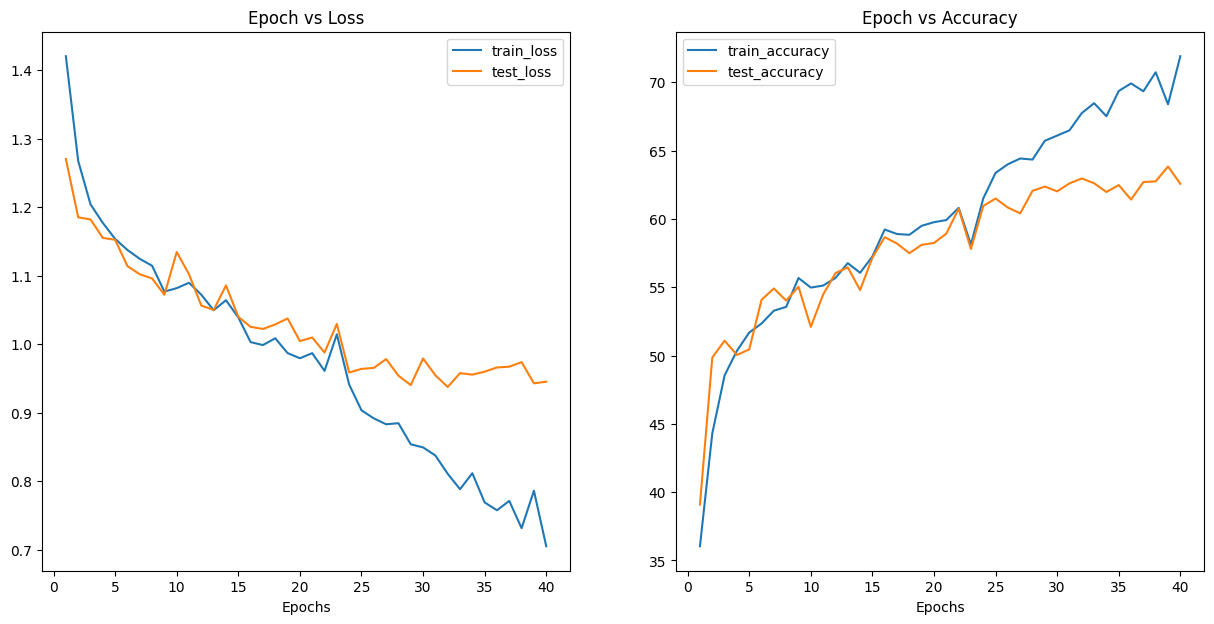

In [60]:
epoch_ls, train_loss_ls, test_loss_ls, train_acc_ls, test_acc_ls = train(model, optimizer, loss_fn, 40)
plot_curve(epoch_ls, train_loss_ls, test_loss_ls, train_acc_ls, test_acc_ls)

###Learnable Positional Embedding, attention heads = 8, encoder blocks = 6, activation ReLU

In [61]:
model = VisionTransformer(learnable_pos_encoding = True, num_heads = 6, num_blocks = 4, activation = 'relu').to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Epochs: 1 | Train Loss: 1.38 | Train Accuracy: 39.54 | Test Loss: 1.23 | Test Accuracy: 45.23
Epochs: 2 | Train Loss: 1.20 | Train Accuracy: 48.36 | Test Loss: 1.17 | Test Accuracy: 51.24
Epochs: 3 | Train Loss: 1.16 | Train Accuracy: 51.23 | Test Loss: 1.14 | Test Accuracy: 52.03
Epochs: 4 | Train Loss: 1.14 | Train Accuracy: 52.41 | Test Loss: 1.12 | Test Accuracy: 51.69
Epochs: 5 | Train Loss: 1.11 | Train Accuracy: 53.89 | Test Loss: 1.11 | Test Accuracy: 53.59
Epochs: 6 | Train Loss: 1.19 | Train Accuracy: 49.46 | Test Loss: 1.16 | Test Accuracy: 49.86
Epochs: 7 | Train Loss: 1.15 | Train Accuracy: 51.93 | Test Loss: 1.10 | Test Accuracy: 53.51
Epochs: 8 | Train Loss: 1.11 | Train Accuracy: 53.60 | Test Loss: 1.08 | Test Accuracy: 56.23
Epochs: 9 | Train Loss: 1.08 | Train Accuracy: 55.39 | Test Loss: 1.07 | Test Accuracy: 55.98
Epochs: 10 | Train Loss: 1.06 | Train Accuracy: 56.23 | Test Loss: 1.08 | Test Accuracy: 55.74
Epochs: 11 | Train Loss: 1.03 | Train Accuracy: 57.75 | Tes

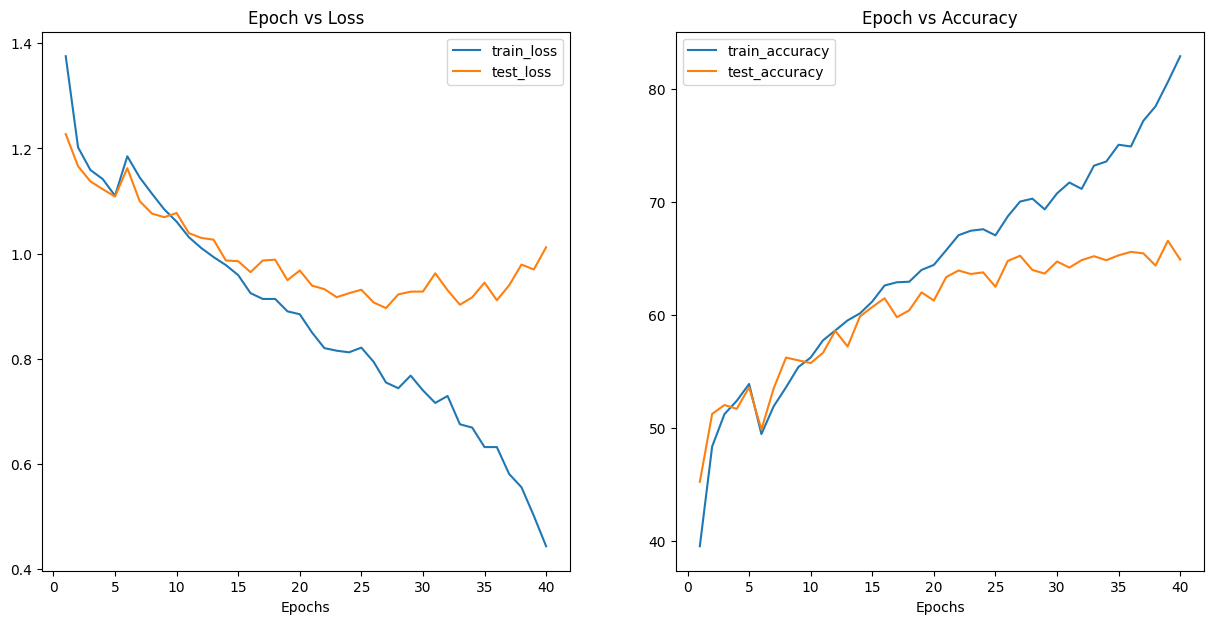

In [62]:
epoch_ls, train_loss_ls, test_loss_ls, train_acc_ls, test_acc_ls = train(model, optimizer, loss_fn, 40)
plot_curve(epoch_ls, train_loss_ls, test_loss_ls, train_acc_ls, test_acc_ls)

###Cosine Positional Embedding, attention heads = 8, encoder blocks = 6, activation Tanh

In [79]:
model = VisionTransformer(learnable_pos_encoding = False, num_heads = 8, num_blocks = 6, activation = 'tanh').to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Epochs: 1 | Train Loss: 1.74 | Train Accuracy: 20.09 | Test Loss: 1.62 | Test Accuracy: 19.84
Epochs: 2 | Train Loss: 1.63 | Train Accuracy: 19.58 | Test Loss: 1.64 | Test Accuracy: 19.84
Epochs: 3 | Train Loss: 1.62 | Train Accuracy: 19.82 | Test Loss: 1.61 | Test Accuracy: 19.84
Epochs: 4 | Train Loss: 1.63 | Train Accuracy: 20.63 | Test Loss: 1.62 | Test Accuracy: 20.12
Epochs: 5 | Train Loss: 1.63 | Train Accuracy: 19.51 | Test Loss: 1.63 | Test Accuracy: 20.03
Epochs: 6 | Train Loss: 1.63 | Train Accuracy: 20.10 | Test Loss: 1.63 | Test Accuracy: 19.96
Epochs: 7 | Train Loss: 1.62 | Train Accuracy: 19.80 | Test Loss: 1.61 | Test Accuracy: 19.96
Epochs: 8 | Train Loss: 1.63 | Train Accuracy: 20.20 | Test Loss: 1.61 | Test Accuracy: 20.03
Epochs: 9 | Train Loss: 1.62 | Train Accuracy: 20.07 | Test Loss: 1.64 | Test Accuracy: 19.84
Epochs: 10 | Train Loss: 1.63 | Train Accuracy: 20.36 | Test Loss: 1.62 | Test Accuracy: 20.05
Epochs: 11 | Train Loss: 1.62 | Train Accuracy: 20.62 | Tes

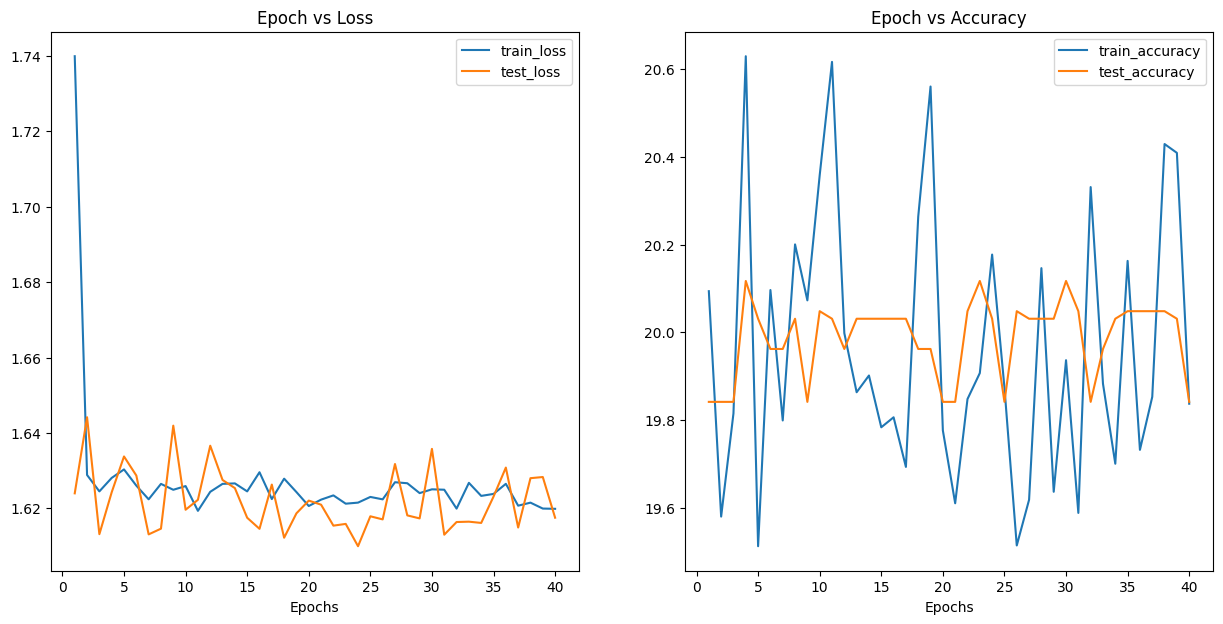

In [80]:
epoch_ls, train_loss_ls, test_loss_ls, train_acc_ls, test_acc_ls = train(model, optimizer, loss_fn, 40)
plot_curve(epoch_ls, train_loss_ls, test_loss_ls, train_acc_ls, test_acc_ls)

###Learnable Positional Embedding, attention heads = 8, encoder blocks = 6, activation Tanh

In [81]:
model = VisionTransformer(learnable_pos_encoding = True, num_heads = 6, num_blocks = 4, activation = 'tanh').to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Epochs: 1 | Train Loss: 1.60 | Train Accuracy: 28.43 | Test Loss: 1.37 | Test Accuracy: 35.04
Epochs: 2 | Train Loss: 1.34 | Train Accuracy: 34.85 | Test Loss: 1.34 | Test Accuracy: 36.97
Epochs: 3 | Train Loss: 1.35 | Train Accuracy: 34.80 | Test Loss: 1.34 | Test Accuracy: 33.84
Epochs: 4 | Train Loss: 1.35 | Train Accuracy: 34.35 | Test Loss: 1.37 | Test Accuracy: 34.08
Epochs: 5 | Train Loss: 1.36 | Train Accuracy: 35.15 | Test Loss: 1.36 | Test Accuracy: 33.52
Epochs: 6 | Train Loss: 1.35 | Train Accuracy: 33.85 | Test Loss: 1.36 | Test Accuracy: 30.78
Epochs: 7 | Train Loss: 1.35 | Train Accuracy: 35.08 | Test Loss: 1.33 | Test Accuracy: 36.21
Epochs: 8 | Train Loss: 1.34 | Train Accuracy: 35.08 | Test Loss: 1.33 | Test Accuracy: 36.01
Epochs: 9 | Train Loss: 1.34 | Train Accuracy: 35.36 | Test Loss: 1.35 | Test Accuracy: 34.73
Epochs: 10 | Train Loss: 1.34 | Train Accuracy: 35.14 | Test Loss: 1.35 | Test Accuracy: 33.95
Epochs: 11 | Train Loss: 1.34 | Train Accuracy: 35.08 | Tes

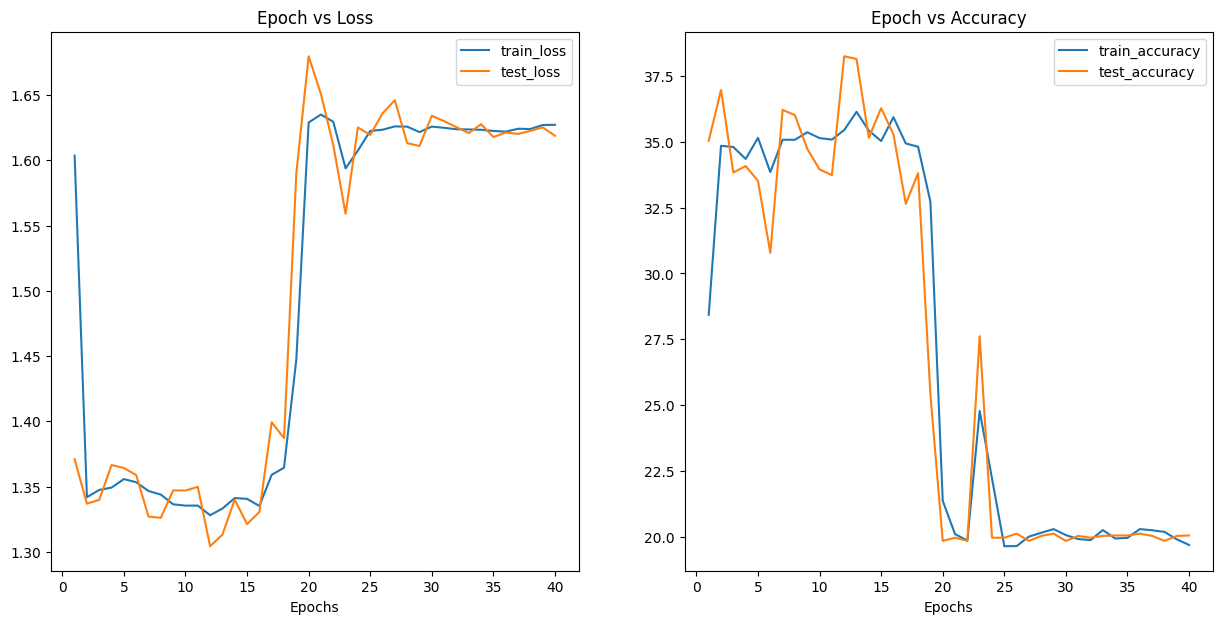

In [82]:
epoch_ls, train_loss_ls, test_loss_ls, train_acc_ls, test_acc_ls = train(model, optimizer, loss_fn, 40)
plot_curve(epoch_ls, train_loss_ls, test_loss_ls, train_acc_ls, test_acc_ls)